# DSAI 305 - Project -  Phase 3
> **Notebook for paper:**  "*Fraud Detection in Financial Transactions: A Machine Learning Approachs*"
>
> https://dx.doi.org/10.2139/ssrn.4439980



by :  `Anas Ahmad Abdelsalam - 202202029`
---
------
-----

`Imports`

In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

filee = "PS_20174392719_1491204439457_log.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ealaxi/paysim1",
  filee,
)

<ipython-input-1-2fa04b40a025>:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 178M/178M [00:05<00:00, 34.8MB/s]

Extracting zip of PS_20174392719_1491204439457_log.csv...


In [2]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

In [4]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=48d39f009a143f41fa2871f02e82526357b900af25a24dece7a526bc6f7c5714
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [5]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, validation_curve, learning_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import lime
import lime.lime_tabular
import warnings
import tensorflow as tf
from google.colab import files
import kagglehub
from kagglehub import KaggleDatasetAdapter
from xgboost import XGBClassifier
from sklearn.metrics import (roc_auc_score, precision_recall_curve, confusion_matrix,
                             classification_report, accuracy_score, roc_curve, auc,
                             precision_score, recall_score, f1_score)
from lime.lime_tabular import LimeTabularExplainer
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Main

## Preprocessing

### `Generic`

In [6]:
df.head(2)

step     type   amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1  PAYMENT  9839.64  C1231006815       170136.0       160296.36   
1     1  PAYMENT  1864.28  C1666544295        21249.0        19384.72   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
# one hot  encoding to 'type'
df = pd.get_dummies(df, columns=['type'])
df.head(2)

#  drop as irrelvant
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)
df.drop(['isFlaggedFraud'], axis=1, inplace=True)

In [9]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
# percentage of isFraude
df['isFraud'].value_counts(normalize=True)

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

In [11]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

`Data`

In [12]:
# print all shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_train_resampled shape: {X_train_resampled.shape}")
print(f"y_train_resampled shape: {y_train_resampled.shape}")

X_train shape: (5090096, 11)
y_train shape: (5090096,)
X_test shape: (1272524, 11)
y_test shape: (1272524,)
X_train_resampled shape: (10167052, 11)
y_train_resampled shape: (10167052,)


In [13]:
# see fraud after applying smote
y_train_resampled.value_counts(normalize=True)

isFraud
0    0.5
1    0.5
Name: proportion, dtype: float64

-----
## Model

`Model`

In [14]:
def tune(model, X, y, param_dist, cv=3, n_iter=20):
    """
    Paper mentioned 3-fold cross-validation using a random search approach
    """
    rs = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='roc_auc',
        cv=cv,
        random_state=42,
        n_jobs=-1
    )
    rs.fit(X, y)
    return rs.best_estimator_, rs.best_params_

# TRAIN (Fixed and Optimized for GPU)
def lgbmTrain(X_train_resampled, y_train_resampled, X_test, y_test):
    """
    Train LightGBM on SMOTE-resampled training data with GPU acceleration and optimizations,
    as per paper's methodology and LightGBM GPU Performance documentation
    """
    # Define LightGBM hyperparameter distribution
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [20, 31, 50],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [0, 0.1, 1],
        'max_bin': [15, 63],         # GPU optimization: smaller bins for speed
        'sparse_threshold': [0.7, 0.8, 0.9]  # Handle sparse one-hot encoded features
    }

    # Initialize LightGBM with GPU support
    mod = LGBMClassifier(
        device='gpu',
        gpu_platform_id=0,
        gpu_device_id=0,
        gpu_use_dp=False,  # Single precision for speed
        max_bin=63,        # Recommended for GPU
        random_state=42
    )

    # Tune model
    best_model, best_params = tune(mod, X_train_resampled, y_train_resampled, param_dist)

    # Train best model with early stopping
    best_model.fit(
        X_train_resampled,
        y_train_resampled,
        eval_set=[(X_test, y_test)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
    )

    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Compute metrics (as per paper)
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    }

    return best_model, best_params, metrics, y_proba, y_pred


`Training Results`

In [15]:
# call the model
model, best_params, metrics, y_proba, y_pred = lgbmTrain(X_train_resampled, y_train_resampled, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
6 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py", 

[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Info] Number of positive: 5083526, number of negative: 5083526
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 10167052, number of used features: 11
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 6 dense feature groups (77.57 MB) transferred to GPU in 0.127350 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Info] Number of positive: 508352

In [24]:
model.booster_.save_model('lightgbm_model.txt')

In [17]:
rep = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(rep).transpose()
report_df.style.background_gradient(cmap='Blues').format('{:.2f}') # to df to plot

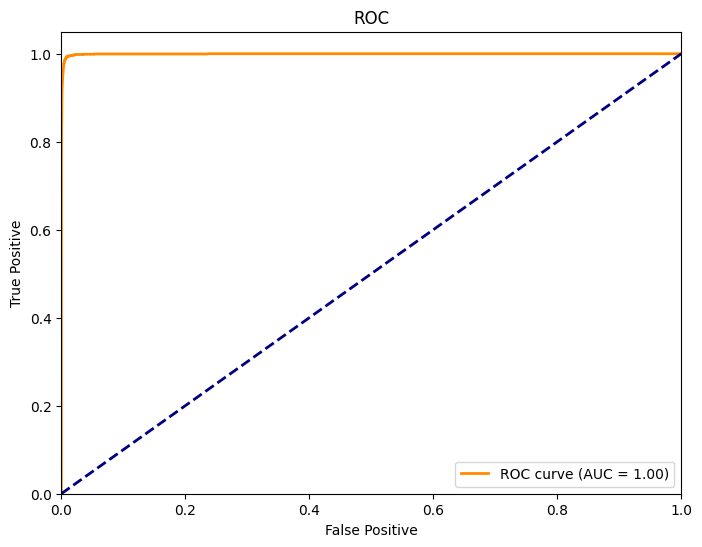

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

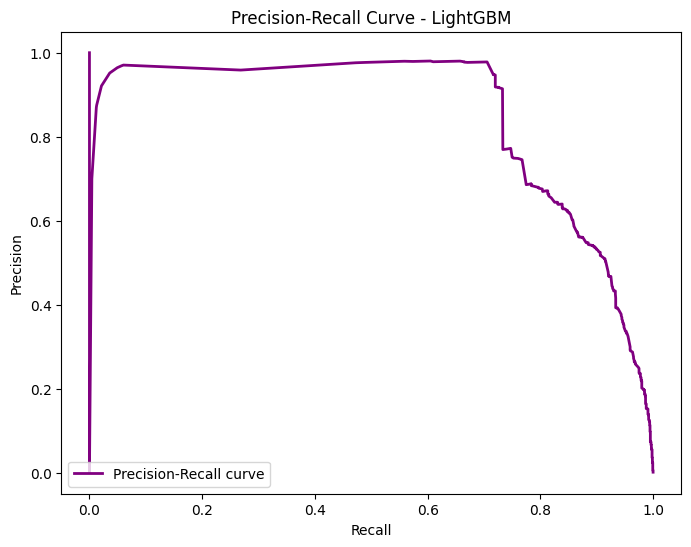

In [23]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - LightGBM')
plt.legend(loc='lower left')
plt.show()

In [25]:
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train_resampled, y_train_resampled,cv=3,scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=1
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 677803
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 677803, number of used features: 11
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 7 dense feature groups (5.17 MB) transferred to GPU in 0.010039 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more le

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 1355606
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 1355606, number of used features: 11
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 7 dense feature groups (10.34 MB) transferred to GPU in 0.019039 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 2033410
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 2033410, number of used features: 11
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 7 dense feature groups (15.51 MB) transferred to GPU in 0.027732 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 2711213
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 2711213, number of used features: 11
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 7 dense feature groups (20.68 MB) transferred to GPU in 0.062244 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 3389017
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 3389017, number of used features: 11
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 7 dense feature groups (25.86 MB) transferred to GPU in 0.045184 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Info] Number of positive: 677803, number of negative: 3389017
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 4066820, number of used features: 11
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 6 dense feature groups (31.03 MB) transferred to GPU in 0.092540 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609439
[LightGBM] [Info] Start training from score -1.609439
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_t

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training AUC', color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation AUC', color='green')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='green')
plt.xlabel('Training Examples')
plt.ylabel('AUC Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.show()

# ---- Explainability -----

### 1. Shap

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


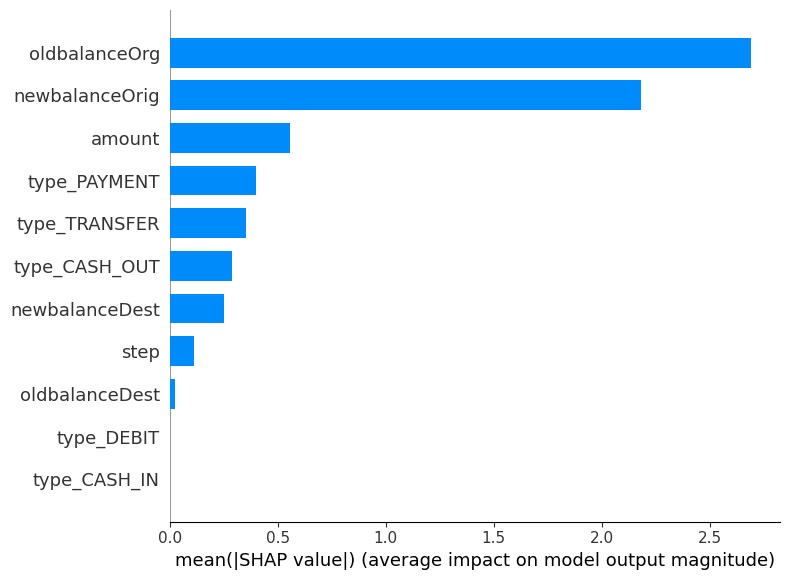

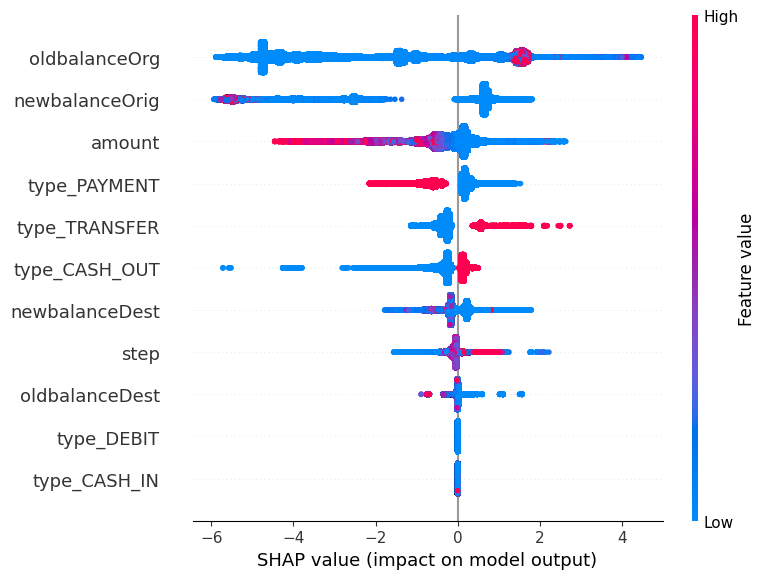

In [30]:

'''used Treeexplainer which is designed to tree based models'''
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
# features global importance
shap.summary_plot(shap_values,X_test, plot_type="bar", feature_names=X_test.columns)

# beeswarm
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

#  first test instance
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values[0,:],X_test.iloc[0,:],feature_names=X_test.columns)

## Lime

In [31]:


from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['non-fraud', 'fraud'],
    mode='classification',
    discretize_continuous=False
)

np.random.seed(42)
quick_idxs = np.random.choice(X_test.shape[0], size=3, replace=False)

for idx in quick_idxs:
    exp = lime_explainer.explain_instance(
        X_test.values[idx],
        model.predict_proba,
        num_features=3,
        num_samples=30
    )
    # to df
    # df_exp = pd.DataFrame(exp.as_list(label=1), columns=['feature', 'weight'])
    print(f"\n ===== LIME Explanation for instance {idx} =====")
    exp.show_in_notebook(show_table=True, show_all=False)
    # display(df_exp)


[LightGBM] [Warning] Unknown parameter: sparse_threshold

 ===== LIME Explanation for instance 349331 =====


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: sparse_threshold

 ===== LIME Explanation for instance 1254732 =====


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: sparse_threshold

 ===== LIME Explanation for instance 58589 =====


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Permutations

[LightGBM] [Warning] Unknown parameter: sparse_threshold


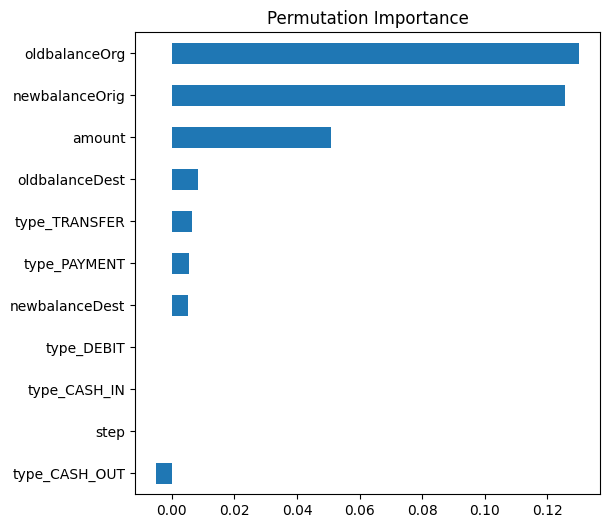

In [33]:
# make feature importance


r = permutation_importance(model, X_test, y_test,
                           n_repeats=10, random_state=42, n_jobs=-1)
pi = pd.Series(r.importances_mean, index=X_test.columns)
pi.sort_values(ascending=False).head(20).plot.barh(figsize=(6,6))
plt.gca().invert_yaxis()
plt.title("Permutation Importance")
plt.show()


## ICE


--- ICE plots ---
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [

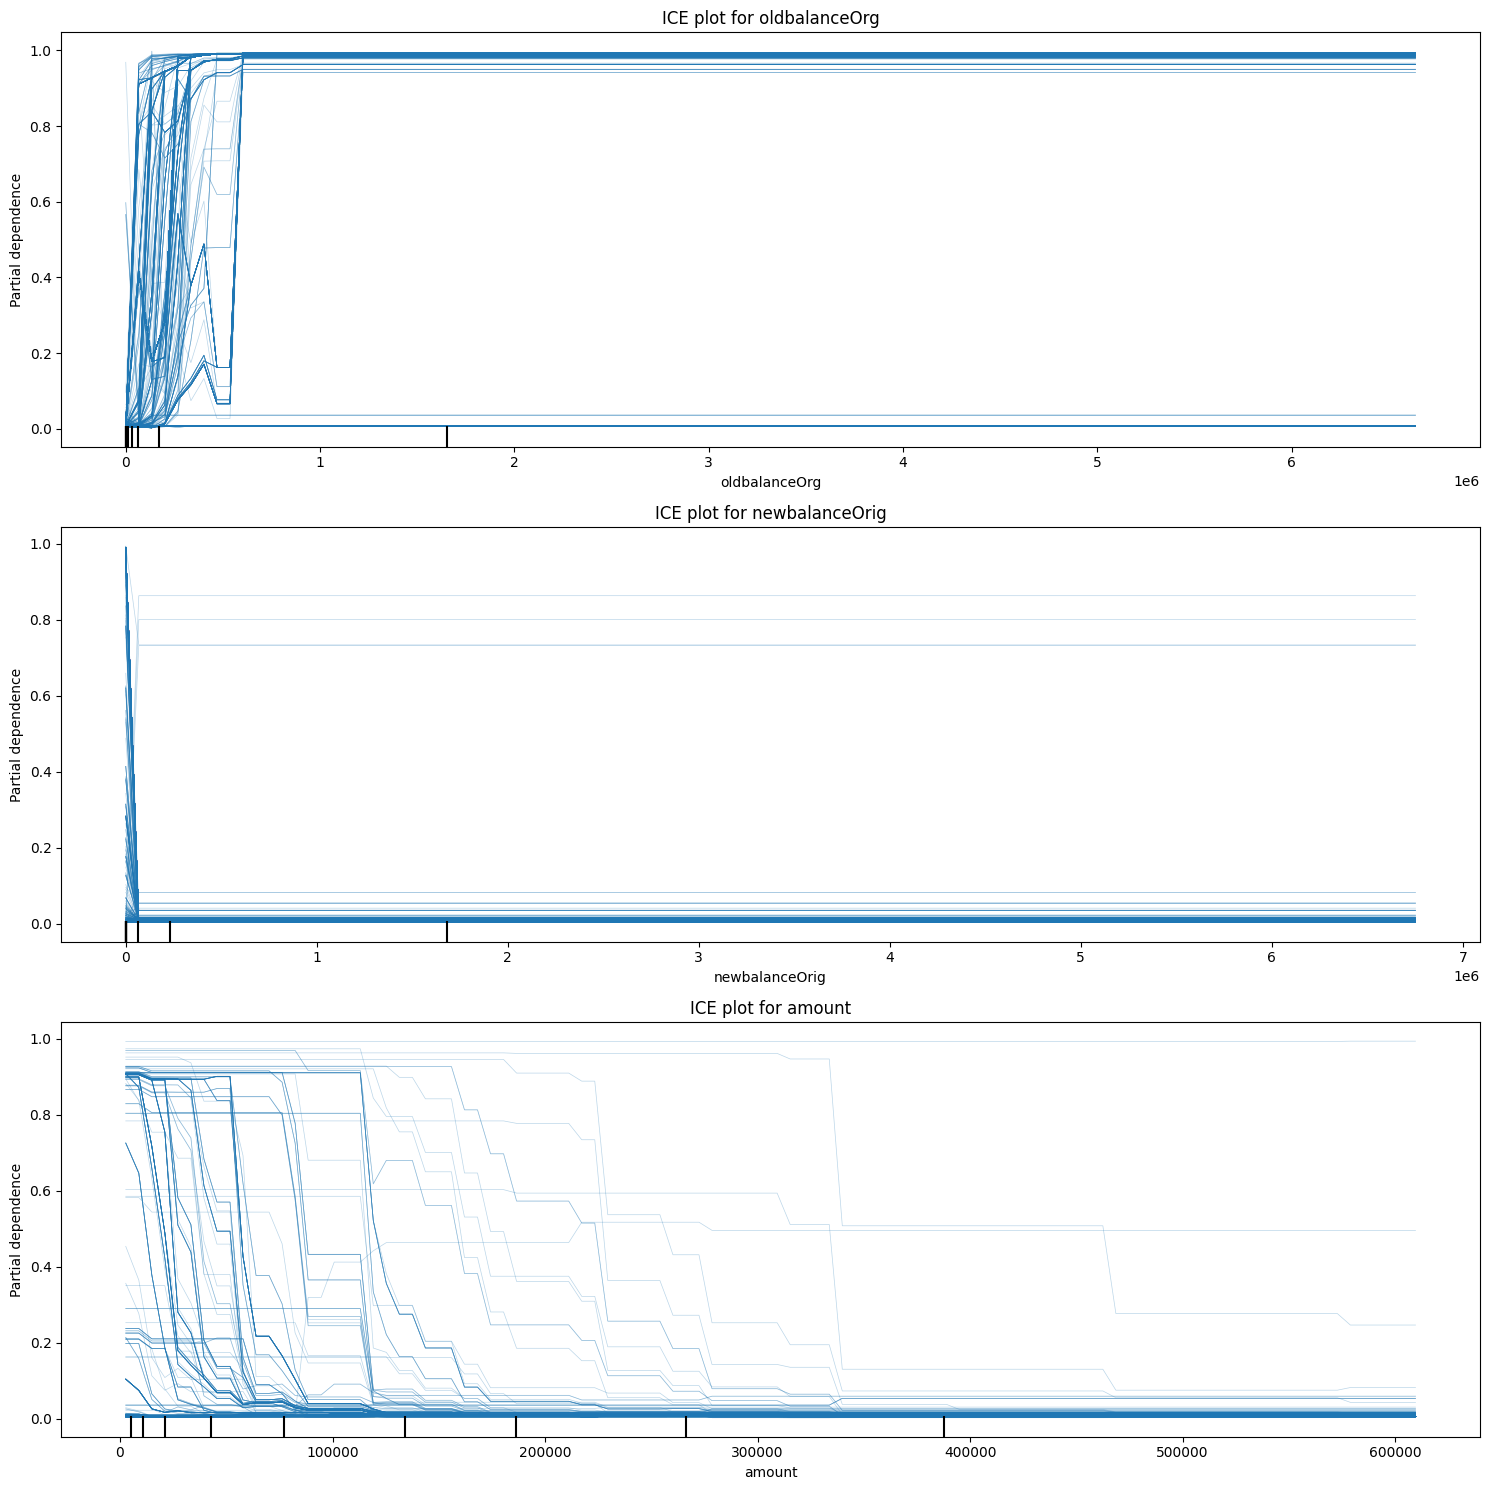

In [34]:
# --- ICE Plots ---
print("\n--- ICE plots ---")


pi = pd.Series(r.importances_mean, index=X_test.columns)
top_features = pi.sort_values(ascending=False).index
numerical_features = [feat for feat in top_features if not feat.startswith('type_')][:3]

#
fig, ax = plt.subplots(figsize=(15, 5 * len(numerical_features)), nrows=len(numerical_features), ncols=1)
for i, feature in enumerate(numerical_features):
    PartialDependenceDisplay.from_estimator(
        model,
        X_test_sample,
        features=[feature],
        kind='individual',
        ax=ax[i],
        random_state=42
    )
    ax[i].set_title(f"ICE plot for {feature}")
plt.tight_layout()
plt.show()